In [1]:
import pandas as pd
pd.options.display.max_columns = 100
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [2]:
train_df_raw = pd.read_excel('relaytrain_2_2_2_2_2.xlsx')
test_df_raw = pd.read_excel('relaytest_2_2_2_2_2.xlsx')
train_df_raw.head()

,custid,retained,created,firstorder,lastorder,esent,eopenrate,eclickrate,avgorder,ordfreq,paperless,refill,doorstep,train,favday,city
0,6H6T6N,0,2012-09-28,2013-08-11 00:00:00,2013-08-11 00:00:00,29,100.000000,3.448276,14.52,0.000000,0,0,0,1,Monday,CHO
1,APCENR,1,2010-12-19,2011-04-01 00:00:00,2014-01-19 00:00:00,95,92.631579,10.526316,83.69,0.181641,1,1,1,1,Friday,CHO
2,7UP6MS,0,2010-10-03,2010-12-01 00:00:00,2011-07-06 00:00:00,0,0.000000,0.000000,33.58,0.059908,0,0,0,1,Wednesday,CHO
3,7ZEW8G,0,2010-10-22,2011-03-28 00:00:00,2011-03-28 00:00:00,0,0.000000,0.000000,54.96,0.000000,0,0,0,1,Thursday,RIC
4,8V726M,1,2010-11-27,2010-11-29 00:00:00,2013-01-28 00:00:00,30,90.000000,13.333333,111.91,0.008850,0,0,0,1,Monday,RIC


In [3]:
# Store labels separately from training data
train_labels = train_df_raw['retained']
test_labels = test_df_raw['retained']

In [4]:
# Remove labels from training data
train_df = train_df_raw.drop('retained', axis=1, inplace=False)
test_df = test_df_raw.drop('retained', axis=1, inplace=False)

# Step 1: Data Exploration

Questions:

* What is the cardinality of city?
* What is the cardinality of custid? Does custid matter (e.g. repeat customers?)
* What is the ratio of customers retained to customers lost?
* Which columns correlate the most with our target?
* Is there any multicollinearity in our dataset?
* Do the dates matter? How can we transform these so that we can use them in our model?

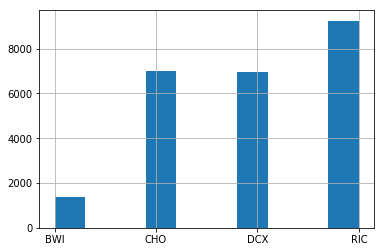

In [5]:
train_df.city.hist()

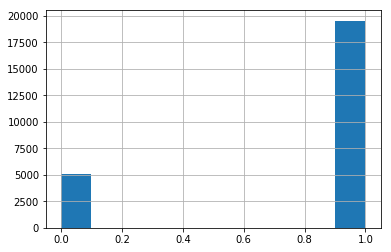

In [6]:
train_labels.hist()

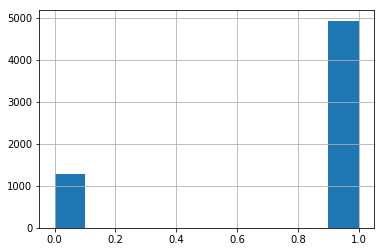

In [7]:
test_labels.hist()

### Class Imbalance!

Our labels have a large class imbalance. Customers lost represent only 25% of our data in both our training and testing sets. We need to balance this using stratified K-Fold Cross Validation, or through Naive Oversampling. 

In [8]:
one_hot_train_df = pd.get_dummies(train_df.drop(['custid', 'train', 'created', 'firstorder', 'lastorder'], axis=1))
one_hot_test_df = pd.get_dummies(test_df.drop(['custid', 'train', 'created', 'firstorder', 'lastorder'], axis=1))
one_hot_train_df.head()
col_names = one_hot_train_df.columns
col_names

Index(['esent', 'eopenrate', 'eclickrate', 'avgorder', 'ordfreq', 'paperless',
       'refill', 'doorstep', 'favday_Friday', 'favday_Monday',
       'favday_Saturday', 'favday_Sunday', 'favday_Thursday', 'favday_Tuesday',
       'favday_Wednesday', 'city_BWI', 'city_CHO', 'city_DCX', 'city_RIC'],
      dtype='object')

In [9]:
one_hot_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24579 entries, 0 to 24578
Data columns (total 19 columns):
esent               24579 non-null int64
eopenrate           24579 non-null float64
eclickrate          24579 non-null float64
avgorder            24579 non-null float64
ordfreq             24579 non-null float64
paperless           24579 non-null int64
refill              24579 non-null int64
doorstep            24579 non-null int64
favday_Friday       24579 non-null uint8
favday_Monday       24579 non-null uint8
favday_Saturday     24579 non-null uint8
favday_Sunday       24579 non-null uint8
favday_Thursday     24579 non-null uint8
favday_Tuesday      24579 non-null uint8
favday_Wednesday    24579 non-null uint8
city_BWI            24579 non-null uint8
city_CHO            24579 non-null uint8
city_DCX            24579 non-null uint8
city_RIC            24579 non-null uint8
dtypes: float64(4), int64(4), uint8(11)
memory usage: 1.8 MB


In [10]:
scaler = StandardScaler()
one_hot_train_df = pd.DataFrame(scaler.fit_transform(one_hot_train_df), columns=col_names)
one_hot_test_df = pd.DataFrame(scaler.fit_transform(one_hot_test_df), columns=col_names)

In [11]:
 rf = RandomForestClassifier()
rf.fit(one_hot_train_df, train_labels)
rf_train_pred = rf.predict(one_hot_train_df)
rf_test_pred = rf.predict(one_hot_test_df)

In [12]:
print("Classification Report: Random Forest (Training)")
print(classification_report(train_labels, rf_train_pred))

print("Classification Report: Random Forest (Testing)")
print(classification_report(test_labels, rf_test_pred))

Classification Report: Random Forest (Training)
             precision    recall  f1-score   support

          0       0.99      0.99      0.99      5042
          1       1.00      1.00      1.00     19537

avg / total       1.00      1.00      1.00     24579

Classification Report: Random Forest (Testing)
             precision    recall  f1-score   support

          0       0.90      0.83      0.86      1287
          1       0.96      0.98      0.97      4935

avg / total       0.95      0.95      0.95      6222



In [65]:
import statsmodels.api as sm
logit_model=sm.Logit(train_labels, one_hot_train_df)
result=logit_model.fit()
print(.summary2())
print(one_hot_train_df.columns)

         Current function value: 0.457925
         Iterations: 35


C:\Users\medio\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AttributeError: 'RFE' object has no attribute 'summary2'

In [73]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
rfe = RFE(logreg, 10)
rfe = rfe.fit(one_hot_train_df, train_labels)
print(rfe.support_)
print(rfe.ranking_)
print(rfe.ranking_)
lr_train_preds = rfe.predict(one_hot_train_df)
lr_test_preds = rfe.predict(one_hot_test_df)

[ True  True  True  True False  True  True  True  True False False  True
 False False False  True False False False]
[ 1  1  1  1  2  1  1  1  1  6 10  1  9  5  7  1  8  4  3]
[ 1  1  1  1  2  1  1  1  1  6 10  1  9  5  7  1  8  4  3]


In [17]:
print("Classification Report: Logistic Regression (Training)")
print(classification_report(train_labels, lr_train_preds))

print("Classification Report: Logistic Regression (Testing)")
print(classification_report(test_labels, lr_test_preds))

Classification Report: Logistic Regression (Training)
             precision    recall  f1-score   support

          0       0.88      0.83      0.85      5042
          1       0.96      0.97      0.96     19537

avg / total       0.94      0.94      0.94     24579

Classification Report: Logistic Regression (Testing)
             precision    recall  f1-score   support

          0       0.89      0.83      0.86      1287
          1       0.96      0.97      0.96      4935

avg / total       0.94      0.94      0.94      6222



In [53]:
from sklearn.metrics import confusion_matrix
import itertools

def show_cf(y_true, y_pred, model_name):
    cf = confusion_matrix(y_true, y_pred)
    plt.imshow(cf, cmap=plt.cm.Blues)
    
    plt.title("Confusion Matrix: {}".format(model_name))
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    class_names = set(test_labels)
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    
    thresh = cf.max() / 2.
    
    for i, j in itertools.product(range(cf.shape[0]), range(cf.shape[1])):
        plt.text(j, i, cf[i, j], horizontalalignment='center', color='white' if cf[i, j] > thresh else 'black')

    plt.colorbar()

In [26]:
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(19,)))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [27]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history = model.fit(one_hot_train_df, train_labels, epochs=20, verbose=1, validation_data=(one_hot_test_df, test_labels))

Train on 24579 samples, validate on 6222 samples
Epoch 1/20
24579/24579 [==============================] - 6s 226us/step - loss: 0.3415 - acc: 0.8532 - val_loss: 0.1875 - val_acc: 0.9396
Epoch 2/20
24579/24579 [==============================] - 2s 96us/step - loss: 0.2071 - acc: 0.9234 - val_loss: 0.1749 - val_acc: 0.9433
Epoch 3/20
24579/24579 [==============================] - 2s 94us/step - loss: 0.1935 - acc: 0.9307 - val_loss: 0.1692 - val_acc: 0.9458
Epoch 4/20
24579/24579 [==============================] - 2s 93us/step - loss: 0.1866 - acc: 0.9345 - val_loss: 0.1675 - val_acc: 0.9457
Epoch 5/20
24579/24579 [==============================] - 2s 93us/step - loss: 0.1794 - acc: 0.9389 - val_loss: 0.1635 - val_acc: 0.9466
Epoch 6/20
24579/24579 [==============================] - 2s 94us/step - loss: 0.1732 - acc: 0.9421 - val_loss: 0.1579 - val_acc: 0.9473
Epoch 7/20
24579/24579 [==============================] - 2s 97us/step - loss: 0.1675 - acc: 0.9430 - val_loss: 0.1551 - val_acc

In [51]:
nn_test_preds = model.predict_classes(one_hot_test_df)

In [29]:
history = history.history

In [30]:
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [31]:
epochs = [i for i in range (1, 21)]

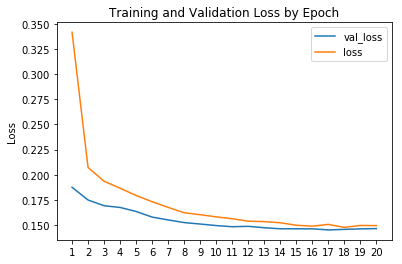

In [32]:
plt.figure()
plt.title('Training and Validation Loss by Epoch')
plt.plot(epochs, history['val_loss'])
plt.plot(epochs, history['loss'])
plt.legend(['val_loss', 'loss'])
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

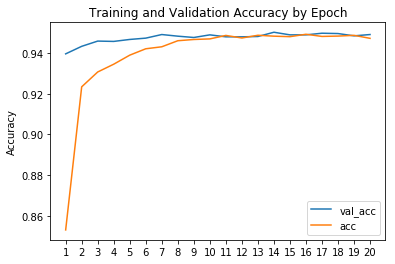

In [33]:
plt.figure()
plt.title('Training and Validation Accuracy by Epoch')
plt.plot(epochs, history['val_acc'])
plt.plot(epochs, history['acc'])
plt.legend(['val_acc', 'acc'])
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.show()

In [34]:
from sklearn.svm import SVC

In [35]:
svc = SVC()
svc.fit(one_hot_train_df, train_labels)
svc_train_preds = svc.predict(one_hot_train_df)
svc_test_preds = svc.predict(one_hot_test_df)

In [36]:
print("Classification Report: Support Vector Machine (Training)")
print(classification_report(train_labels, svc_train_preds))

print("Classification Report: Support Vector Machine (Testing)")
print(classification_report(test_labels, svc_test_preds))

Classification Report: Support Vector Machine (Training)
             precision    recall  f1-score   support

          0       0.93      0.81      0.87      5042
          1       0.95      0.99      0.97     19537

avg / total       0.95      0.95      0.95     24579

Classification Report: Support Vector Machine (Testing)
             precision    recall  f1-score   support

          0       0.93      0.79      0.85      1287
          1       0.95      0.98      0.97      4935

avg / total       0.94      0.94      0.94      6222



# TODO

Histogram of model statistics 

Brief write-up of each step

Recommended improvements

Explore logistic regression coefficients

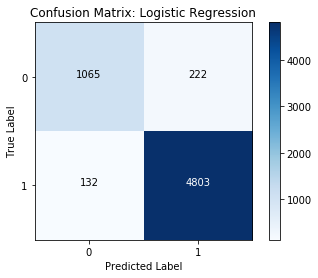

In [54]:
show_cf(test_labels, lr_test_preds, "Logistic Regression")

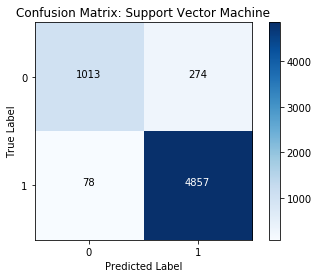

In [43]:
show_cf(test_labels, svc_test_preds, "Support Vector Machine")

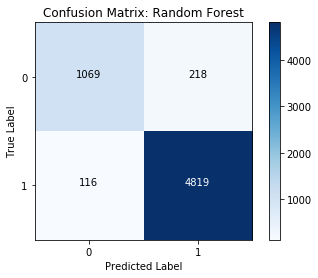

In [46]:
show_cf(test_labels, rf_test_pred, "Random Forest")

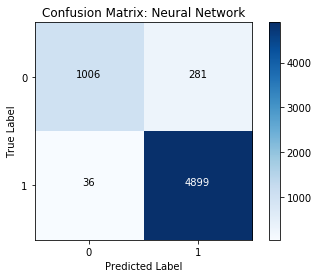

In [52]:
show_cf(test_labels, nn_test_preds, "Neural Network")

In [63]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

def model_stats(y_true, y_pred, model_name):
    print('-'*40)
    print("Model Performance Statistics on Test Set for {}".format(model_name))
    
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print("Precision: {:.4f}%".format(precision * 100))
    print("Recall: {:.4f}%".format(recall * 100))
    print("Accuracy: {:.4f}%".format(accuracy * 100))
    print("F1 Score: {:.4f}%".format(f1 * 100))
    
    

In [64]:
results = [lr_test_preds, rf_test_pred, svc_test_preds, nn_test_preds]
model_names = ['Logistic Regression', "Random Forest", "Support Vector Machine", "Neural Network"]
for ind, val in enumerate(results):
    model_stats(test_labels, results[ind], model_names[ind])

----------------------------------------
Model Performance Statistics on Test Set for Logistic Regression
Precision: 95.5821%
Recall: 97.3252%
Accuracy: 94.3105%
F1 Score: 96.4458%
----------------------------------------
Model Performance Statistics on Test Set for Random Forest
Precision: 95.6720%
Recall: 97.6494%
Accuracy: 94.6320%
F1 Score: 96.6506%
----------------------------------------
Model Performance Statistics on Test Set for Support Vector Machine
Precision: 94.6599%
Recall: 98.4195%
Accuracy: 94.3427%
F1 Score: 96.5031%
----------------------------------------
Model Performance Statistics on Test Set for Neural Network
Precision: 94.5753%
Recall: 99.2705%
Accuracy: 94.9052%
F1 Score: 96.8660%


|          Model         | Precision |  Recall  | Accuracy | F1-Score |
|:----------------------:|:---------:|:--------:|:--------:|:--------:|
|   Logistic Regression  |  95.5821% | 97.3252% | 94.3105% | 95.4458% |
|      Random Forest     |  **95.6720%** | 97.6494% | 94.6320% | 96.5606% |
| Support Vector Machine |  94.6599% | 98.4195% | 94.3427% | 96.5031% |
|     Neural Network     |  94.5753% | **99.2705%** | **94.9052%** | **96.8660%** |